In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import fsolve
from itertools import permutations

In [2]:
def generate_random_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        a, b = random.uniform(-1, 1), random.uniform(-1, 1)
        c, d = random.uniform(-1, 1), random.uniform(-1, 1)
        e, f = random.uniform(-1, 1), random.uniform(-1, 1)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())

    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities

def generate_self_similar_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        # scale = random.uniform(0.2, 0.7)
        scale = random.uniform(0.2, 0.5)
        angle = random.uniform(0, 2 * math.pi)

        a = scale * math.cos(angle)
        b = -scale * math.sin(angle)
        c = scale * math.sin(angle)
        d = scale * math.cos(angle)

        # e = random.uniform(-1, 1)
        # f = random.uniform(-1, 1)
        e = random.uniform(-0.3, 0.3)
        f = random.uniform(-0.3, 0.3)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities


def apply_transform(x, y, transform):
    a, b, c, d, e, f = transform
    new_x = a * x + b * y + e
    new_y = c * x + d * y + f
    return new_x, new_y

def generate_fractal(transformations, probabilities, n_points=100000):
    """Generate fractal points using an IFS."""
    x, y = 0, 0
    points = []

    for _ in range(n_points):
        transform = random.choices(transformations, weights=probabilities, k=1)[0]
        x, y = apply_transform(x, y, transform)
        points.append((x, y))

    return points


In [3]:
def calculate_scaling_factors(transformations):
    scaling_factors = []
    for t in transformations:
        a, b, c, d, _, _ = t
        singular_values = np.linalg.svd([[a, b], [c, d]], compute_uv=False)
        scaling_factors.append(max(singular_values))
    return scaling_factors

def similarity_dimension(scaling_factors):
    def equation(D):
        return sum(s ** D for s in scaling_factors) - 1
    D_initial_guess = 1.0
    D_solution = fsolve(equation, D_initial_guess)
    return D_solution[0]

In [4]:
# from scipy.stats import linregress

# def plot_reg(logs, logN, slope, intercept):
#     plt.scatter(logs, logN, color='blue', label='Punkty danych')
    
#     plt.plot(logs, slope * logs + intercept, color='red', label=f'Regresja: y = {slope:.2f}x + {intercept:.2f}')
#     plt.xlabel('log(epsilons)')
#     plt.ylabel('log(N)')
#     plt.legend()
#     plt.title('Regresja liniowa dla wymiaru boxowego')
#     plt.show()
    
#     return

# def compute_box_dimension_3D(X, epsilons):
#     counts = []
#     eps = []
    
#     for epsilon in epsilons:
#         intervals = int(1 / epsilon)
#         n_points = int(len(X)/intervals)
#         count = 0

#         for i in range(int(intervals)):
#             for j in range(int(intervals)):
#                 in_range = int((np.max(X[i*n_points:(i+1)*n_points-1, j*n_points:(j+1)*n_points-1]) - np.min(X[i*n_points:(i+1)*n_points-1, j*n_points:(j+1)*n_points-1])) / epsilon)
#                 count += in_range

#         if count > 0:
#             counts.append(count)
#             eps.append(epsilon)

#     logs = np.log(1/np.array(eps))
#     logN = np.log(counts)

#     slope, intercept, _, _, _ = linregress(logs, logN)
    
#     plot_reg(logs, logN, slope, intercept)
    
#     return slope
# epsilons = []
# for i in range(8):
#     epsilons = epsilons + [1/(2**i)]
    
# print(epsilons)

# # H = 0.5  # wykładnik Hursta
# # # surface_h1 = fbm2D(H, shape=(1024, 1024))

# # # Obliczanie wymiaru boxowego
# # dimension = compute_box_dimension_3D(surface_h1, epsilons)
# # print(f"Wymiar boxowy: {dimension}")

In [5]:
# from scipy.stats import linregress

# def box_count_2d(points, eps):
#     """
#     Zwraca liczbę kwadratów o boku eps, w których znajduje się 
#     co najmniej jeden punkt z listy points.
#     """
#     x_coords, y_coords = zip(*points)
#     min_x, max_x = min(x_coords), max(x_coords)
#     min_y, max_y = min(y_coords), max(y_coords)

#     # przesuwamy układ tak, aby (min_x, min_y) było (0,0) - ułatwia indeksowanie
#     shifted_x = [x - min_x for x in x_coords]
#     shifted_y = [y - min_y for y in y_coords]

#     width = max_x - min_x
#     height = max_y - min_y

#     # liczba boksów w osi x oraz y
#     Nx = int(np.ceil(width / eps))
#     Ny = int(np.ceil(height / eps))

#     # tablica logiczna, True oznacza "zajęty boks"
#     occupancy = np.zeros((Nx, Ny), dtype=bool)

#     for x, y in zip(shifted_x, shifted_y):
#         ix = int(x // eps)
#         iy = int(y // eps)
#         # Zabezpieczenie przed ewentualnym wyjściem poza index:
#         if ix >= Nx: ix = Nx - 1
#         if iy >= Ny: iy = Ny - 1
#         occupancy[ix, iy] = True

#     return np.sum(occupancy)

# def compute_box_dimension_2d(points, epsilons):
#     """
#     Oblicza box-counting dimension w 2D na podstawie listy punktów.
#     Zwraca oszacowanie wymiaru (nachylenie w regresji log-log).
#     """
#     counts = []
#     for eps in epsilons:
#         N = box_count_2d(points, eps)
#         counts.append(N if N > 0 else 1)

#     # log(N) vs log(1/eps)
#     logs = np.log(1 / np.array(epsilons))
#     log_counts = np.log(counts)

#     slope, intercept, r_value, p_value, std_err = linregress(logs, log_counts)
#     return slope, intercept, r_value, p_value, std_err

# def plot_regression(logs, logN, slope, intercept):
#     plt.figure(figsize=(5,4))
#     plt.scatter(logs, logN, color='blue', label='Punkty danych')
    
#     fit_line = slope * logs + intercept
#     plt.plot(logs, fit_line, color='red', 
#              label=f'Regresja: y = {slope:.2f}x + {intercept:.2f}')
#     plt.xlabel('log(1/epsilon)')
#     plt.ylabel('log(N(epsilon))')
#     plt.legend()
#     plt.title('Regresja liniowa (Box Counting Dimension)')
#     plt.show()

# def adaptive_epsilons(points):
#     min_x = np.min(points[:,0])
#     max_x = np.max(points[:,0])
#     min_y = np.min(points[:,1])
#     max_y = np.max(points[:,1])

#     delta_x = max_x - min_x
#     delta_y = max_y - min_y
#     box_size = max(delta_x, delta_y)

#     epsilons = []
#     while True:
#         # Liczba boksów w każdej osi przy aktualnym eps
#         Nx = box_size / box_size   # = 1.0 dla startu
#         # Nx = int(np.ceil(delta_x / box_size)) itd.
#         # ...
#         # Ale w prostszym wariancie można co iterację:
#         epsilons.append(box_size)

#         # Warunek wyjścia z pętli: np. jeśli box_size < ...
#         if box_size < 1e-4:  # albo inny próg
#             break

#         # schodzimy o czynnik 2
#         box_size /= 2.0

#     return epsilons


# def show_results(transformations, probabilities, epsilons=None):
#     # 1. Generujemy punkty fraktala
#     points = generate_fractal(transformations, probabilities, n_points=1000000)
#     x_coords, y_coords = zip(*points)
    
#     # 2. Rysujemy fraktal
#     plt.figure(figsize=(5, 5))
#     plt.scatter(x_coords, y_coords, s=0.1, color="black")
#     plt.axis("off")
#     plt.title("Fractal Generated by IFS")
#     plt.show()
    
#     scaling_factors = calculate_scaling_factors(transformations)
#     dimension = similarity_dimension(scaling_factors)
#     print(f"Similarity dimension ≈ {dimension:.4f}")

#     # 3. Obliczamy wymiar fraktalny metodą box counting
#     # if epsilons is None:
#     #     # przykładowy wybór rozmiarów boksów
#     #     epsilons = [2**(-i) for i in range(1, 7)]
#     if epsilons is None:
#     # przykładowy wybór rozmiarów boksów: od 2^-1 do 2^-10
#         epsilons = [2**(-i) for i in range(1, 10)]

    
#     slope, intercept, r_value, p_value, std_err = compute_box_dimension_2d(points, epsilons)
#     print(f"Box-counting dimension ≈ {slope:.4f}")
    
#     # (opcjonalnie) pokazujemy wykres regresji
#     logs = np.log(1 / np.array(epsilons))
#     log_counts = np.log([box_count_2d(points, e) for e in epsilons])
#     plot_regression(logs, log_counts, slope, intercept)

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress

# ====== Twoje/Podstawowe funkcje IFS (muszą być wcześniej zdefiniowane) ======
# generate_fractal(transformations, probabilities, n_points=100000)
# calculate_scaling_factors(transformations)
# similarity_dimension(scaling_factors)

def box_count_2d(points, eps):
    """
    Zwraca liczbę kwadratów o boku eps, w których znajduje się 
    co najmniej jeden punkt z listy points.
    
    UWAGA: Zakładamy, że 'points' jest już znormalizowane do [0,1] x [0,1].
    """
    x_coords, y_coords = points[:, 0], points[:, 1]

    # liczba boksów w osi x oraz y
    Nx = int(np.ceil(1.0 / eps))
    Ny = int(np.ceil(1.0 / eps))

    occupancy = np.zeros((Nx, Ny), dtype=bool)

    for x, y in zip(x_coords, y_coords):
        ix = int(x // eps)
        iy = int(y // eps)
        # Zabezpieczenie przed ewentualnym wyjściem poza index (0-based)
        if ix >= Nx: 
            ix = Nx - 1
        if iy >= Ny: 
            iy = Ny - 1
        occupancy[ix, iy] = True

    return np.sum(occupancy)


def compute_box_dimension_2d(points, epsilons, skip_extremes=0):
    """
    Oblicza box-counting dimension w 2D na podstawie listy punktów (w formie ndarray Nx2).
    Zwraca: (slope, intercept, r_value, p_value, std_err, logs, log_counts).

    Parametr skip_extremes określa, ile skrajnych wartości eps (największych i najmniejszych)
    pomijamy przy dopasowaniu regresji log-log.
    """
    from scipy.stats import linregress

    # Liczymy N(eps) dla każdej eps
    counts = []
    for eps in epsilons:
        N = box_count_2d(points, eps)  # Twoja funkcja licząca liczbę niepustych boksów
        counts.append(N if N > 0 else 1)

    # Przygotowujemy dane do regresji: log(N) vs log(1/eps)
    logs = np.log(1 / np.array(epsilons))   # oś x
    log_counts = np.log(counts)            # oś y

    # Pomijamy skip_extremes z przodu i z tyłu (o ile skip_extremes > 0)
    if skip_extremes > 0:
        # Upewniamy się, że mamy wystarczająco dużo punktów
        if 2 * skip_extremes < len(epsilons):
            logs_for_regression = logs[skip_extremes:-skip_extremes]
            log_counts_for_regression = log_counts[skip_extremes:-skip_extremes]
        else:
            # Jeśli mamy za mało epsilons, żeby w ogóle coś zostało po obcięciu
            logs_for_regression = logs
            log_counts_for_regression = log_counts
    else:
        # Bez pomijania
        logs_for_regression = logs
        log_counts_for_regression = log_counts

    # Regresja liniowa
    slope, intercept, r_value, p_value, std_err = linregress(logs_for_regression, log_counts_for_regression)

    return slope, intercept, r_value, p_value, std_err, logs, log_counts



def plot_regression(logs, logN, slope, intercept, skip_extremes=1):
    """
    Rysuje punkty (logs, logN) oraz linię regresji.
    skip_extremes - ile skrajnych wartości w obie strony pominięto przy dopasowaniu.
    """
    plt.figure(figsize=(5,4))
    plt.scatter(logs, logN, color='blue', label='Punkty danych')
    
    # Dla porównania - narysujemy 'fit' na całym zakresie, ale
    # był wyznaczany bez kilku skrajnych punktów (o ile skip_extremes>0).
    slope_line = slope * logs + intercept
    plt.plot(logs, slope_line, color='red', label=f'Regresja: slope={slope:.3f}')
    
    plt.xlabel('log(1/ε)')
    plt.ylabel('log(N(ε))')
    plt.title('Regresja liniowa (Box Counting Dimension)')
    plt.legend()
    plt.show()


def normalize_to_unit_square(points):
    """
    Przeskalowuje punkty (x,y), aby ich bounding box mieścił się w [0,1] x [0,1].
    Zwraca ndarray Nx2.
    """
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)

    min_x, max_x = np.min(x_coords), np.max(x_coords)
    min_y, max_y = np.min(y_coords), np.max(y_coords)

    width = max_x - min_x
    height = max_y - min_y

    # Zapobiegamy dzieleniu przez zero (np. jeśli fraktal jest degenerate w jednej osi)
    if width == 0: 
        width = 1e-12
    if height == 0: 
        height = 1e-12

    norm_x = (x_coords - min_x) / width
    norm_y = (y_coords - min_y) / height

    return np.column_stack((norm_x, norm_y))


def adaptive_epsilons(points, min_eps=1e-4, max_divisions=10):
    """
    Przykład adaptacyjnego doboru epsilons:
    - Startujemy od eps = 1.0 (zakładając, że points są w [0,1]^2 po normalizacji)
    - schodzimy w dół 2x max_divisions razy, dopóki eps > min_eps.
    """
    eps = 1.0
    epsilons = []
    for i in range(max_divisions):
        if eps < min_eps:
            break
        epsilons.append(eps)
        eps /= 2.0

    return epsilons


def show_results(transformations, probabilities, epsilons=None, n_points=10000000, skip_extremes=2):
    """
    - Generuje punkty fraktala,
    - Normalizuje je,
    - Oblicza i wyświetla wymiar similarity i box-counting,
    - Rysuje wykres log-log z uwzględnieniem skip_extremes.
    """
    # 1. Generujemy punkty fraktala
    raw_points = generate_fractal(transformations, probabilities, n_points=n_points)
    # 2. Normalizujemy je do [0,1] x [0,1]
    norm_points = normalize_to_unit_square(raw_points)

    # 3. Rysunek surowych punktów (opcjonalnie)
    x_coords, y_coords = zip(*raw_points)
    plt.figure(figsize=(5,5))
    plt.scatter(x_coords, y_coords, s=0.1, color="black")
    plt.axis("off")
    plt.title("Fractal Generated by IFS")
    plt.show()

    # 4. Wymiar podobieństwa (opcjonalnie)
    scaling_factors = calculate_scaling_factors(transformations)
    similarity_dim = similarity_dimension(scaling_factors)
    print(f"Similarity dimension ≈ {similarity_dim:.4f}")

    # 5. Przygotowanie epsilons (jeśli None)
    if epsilons is None:
        # na przykład 9 wartości, 2^-1 do 2^-9
        epsilons = [2**(-i) for i in range(1, 13)]

    # 6. Obliczamy wymiar box-counting z pominięciem skrajnych wartości
    slope, intercept, r_value, p_value, std_err, logs, log_counts = compute_box_dimension_2d(
        norm_points,
        epsilons,
        skip_extremes=skip_extremes
    )
    print(f"Box-counting dimension (skip_extremes={skip_extremes}): {slope:.4f}")
    print(f"  r_value={r_value:.4f}, p_value={p_value:.4g}, std_err={std_err:.4f}")

    # 7. Rysunek log(N) vs log(1/eps)
    plt.figure(figsize=(6,4))
    plt.scatter(logs, log_counts, color='blue', label='All points')
    
    # Rysujemy linię regresji (uwzględniając pominięcie skrajnych punktów)
    slope_line = slope * logs + intercept
    plt.plot(logs, slope_line, color='red',
             label=f'Regresja (skip_ext={skip_extremes}): slope={slope:.3f}')
    plt.xlabel('log(1/ε)')
    plt.ylabel('log(N(ε))')
    plt.title('Box Counting with Skipped Extremes')
    plt.legend()
    plt.show()


In [6]:
# def show_results(transformations, probabilities):
#     points = generate_fractal(transformations, probabilities, n_points=100000)

#     x_coords, y_coords = zip(*points)

#     plt.figure(figsize=(5, 5))
#     plt.scatter(x_coords, y_coords, s=0.1, color="black")
#     plt.axis("off")
#     plt.title("Random Fractal Generated by IFS")
#     plt.show()

#     scaling_factors = calculate_scaling_factors(transformations)

#     dimension = similarity_dimension(scaling_factors)
#     print(f"Approximate Fractal Dimension: {dimension:.4f}")

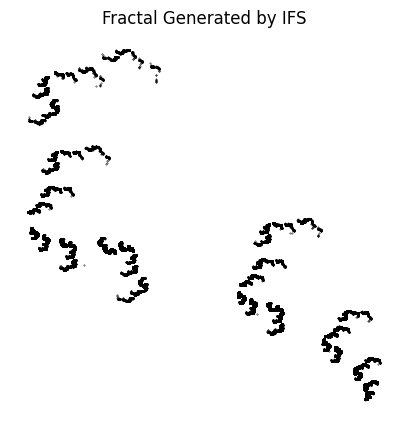

Similarity dimension ≈ 1.1820
Box-counting dimension (skip_extremes=2): 1.1077
  r_value=0.9986, p_value=6.255e-09, std_err=0.0236


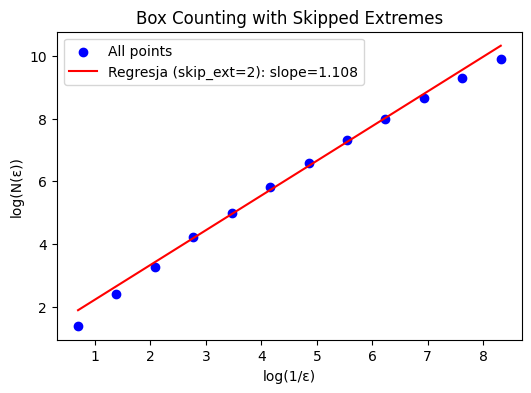

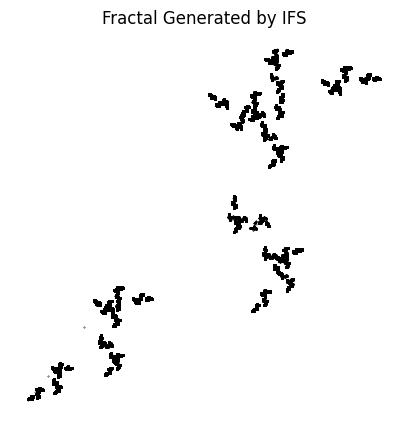

Similarity dimension ≈ 1.1433
Box-counting dimension (skip_extremes=2): 1.1486
  r_value=0.9997, p_value=1.021e-10, std_err=0.0123


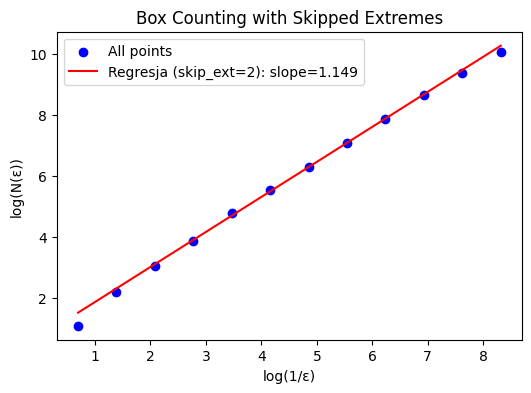

In [7]:
n_transforms = 3
for i in range(1,3):
    transformations, probabilities = generate_self_similar_ifs(n_transforms)
    show_results(transformations, probabilities)

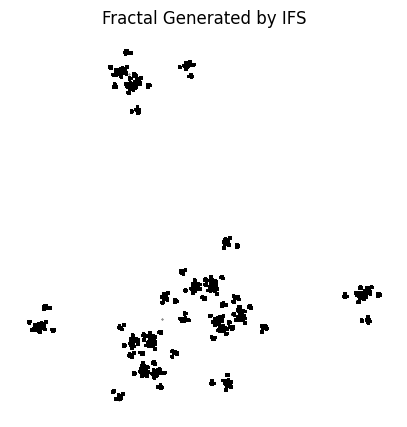

Similarity dimension ≈ 1.0899
Box-counting dimension (skip_extremes=2): 1.1221
  r_value=0.9996, p_value=1.565e-10, std_err=0.0129


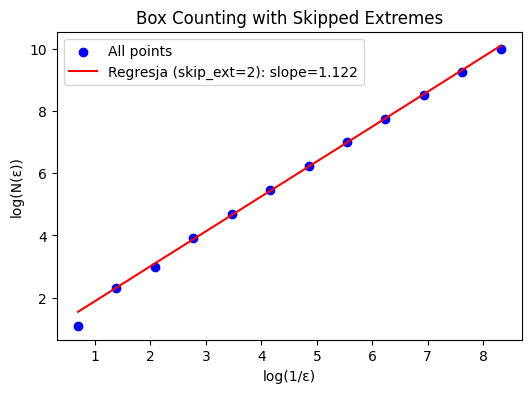

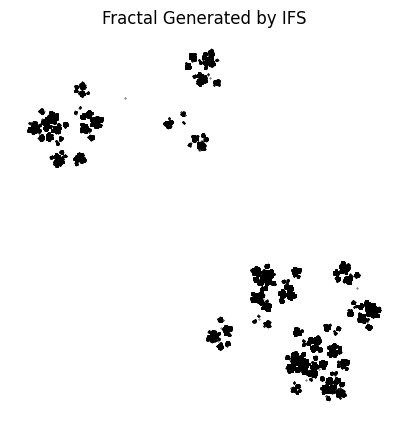

Similarity dimension ≈ 1.3986
Box-counting dimension (skip_extremes=2): 1.2741
  r_value=0.9999, p_value=3.695e-12, std_err=0.0079


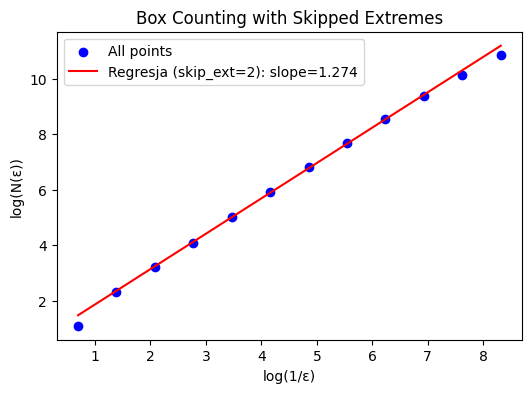

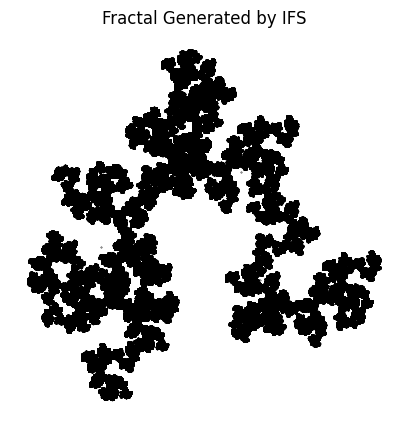

Similarity dimension ≈ 1.8274
Box-counting dimension (skip_extremes=2): 1.7262
  r_value=1.0000, p_value=1.251e-14, std_err=0.0041


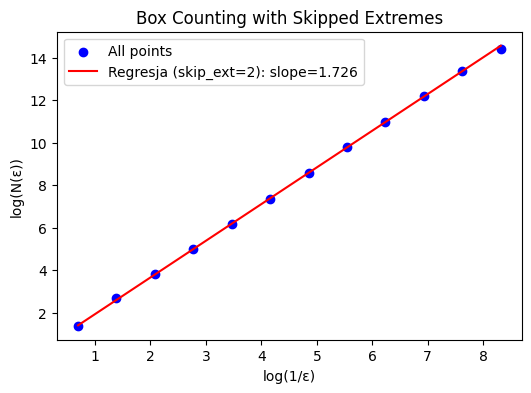

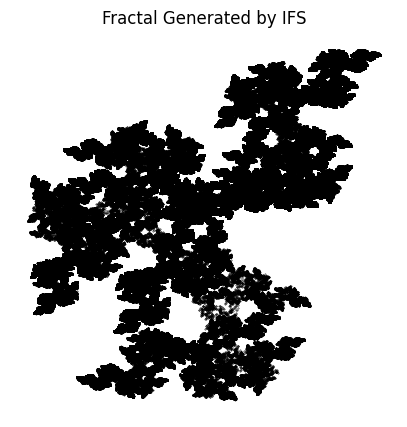

Similarity dimension ≈ 1.9216
Box-counting dimension (skip_extremes=2): 1.7666
  r_value=0.9999, p_value=5.198e-12, std_err=0.0115


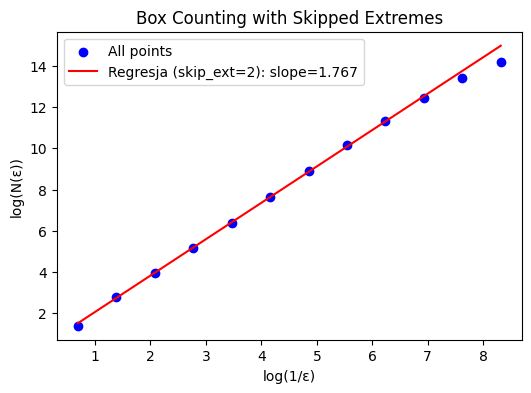

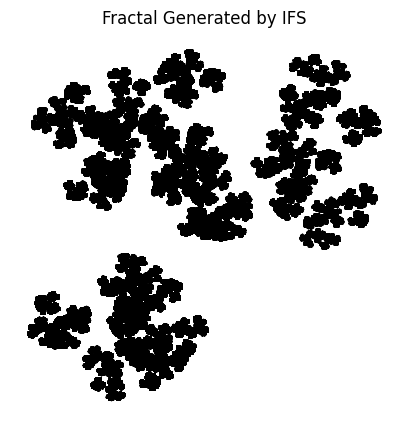

Similarity dimension ≈ 1.8061
Box-counting dimension (skip_extremes=2): 1.6902
  r_value=1.0000, p_value=9.007e-14, std_err=0.0056


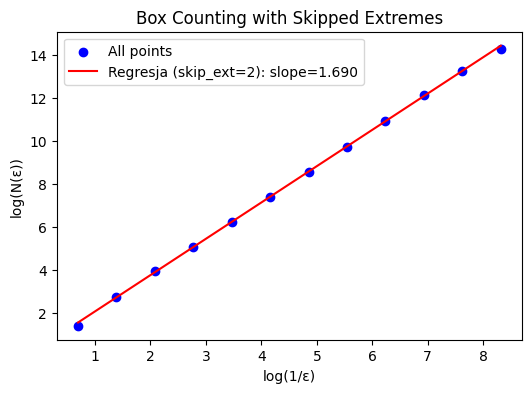

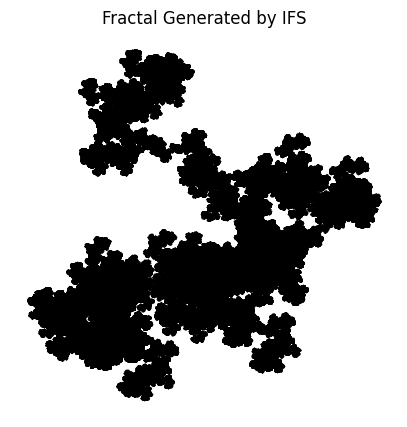

Similarity dimension ≈ 2.2490
Box-counting dimension (skip_extremes=2): 1.8196
  r_value=0.9999, p_value=5.139e-12, std_err=0.0118


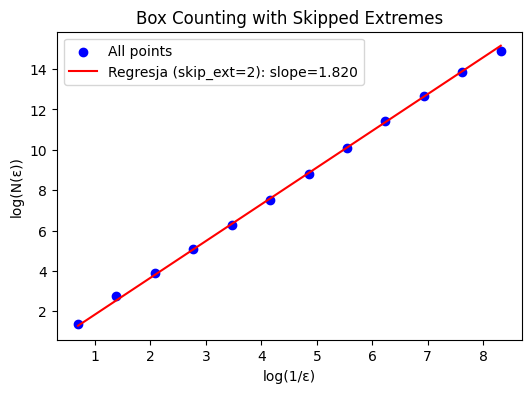

In [8]:
for i in range(3,9):
    transformations, probabilities = generate_self_similar_ifs(i)
    show_results(transformations, probabilities)

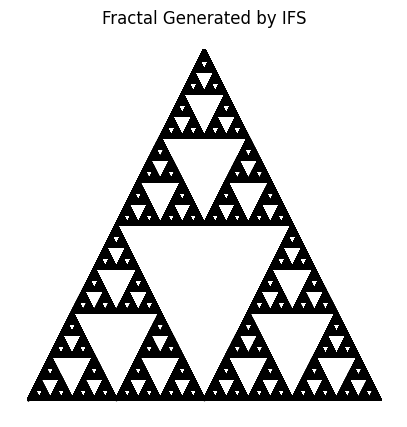

Similarity dimension ≈ 1.5850
Box-counting dimension (skip_extremes=2): 1.5899
  r_value=1.0000, p_value=1.478e-15, std_err=0.0027


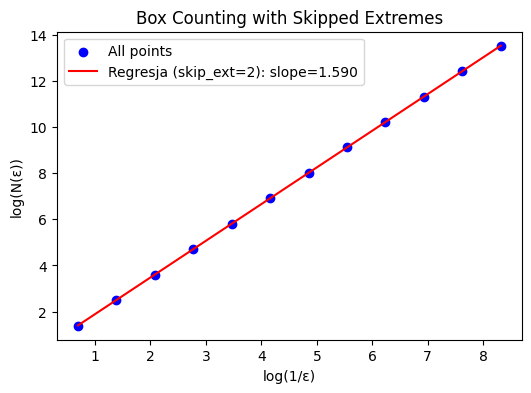

In [9]:
#SIERPINSKI'S TRIANGLE
#expected dim = 1.585
transformations = [
    (0.5, 0.0, 0.0, 0.5, 0.0, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.5, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.25, 0.433),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

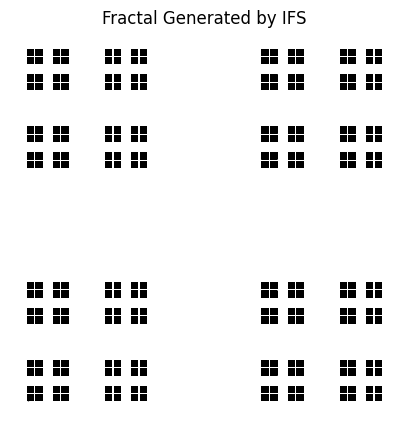

Similarity dimension ≈ 1.2619
Box-counting dimension (skip_extremes=2): 1.3452
  r_value=0.9988, p_value=4.391e-09, std_err=0.0270


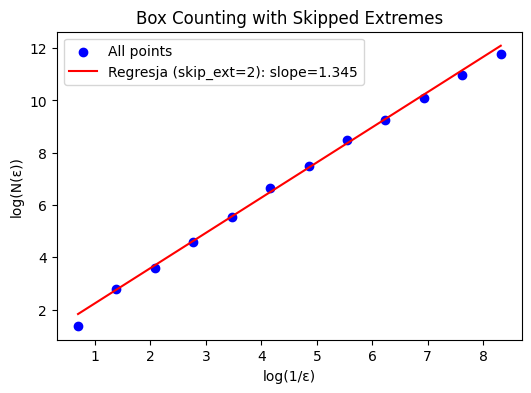

In [10]:
# CANTOR DUST
# Expected dim = 1.26186
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

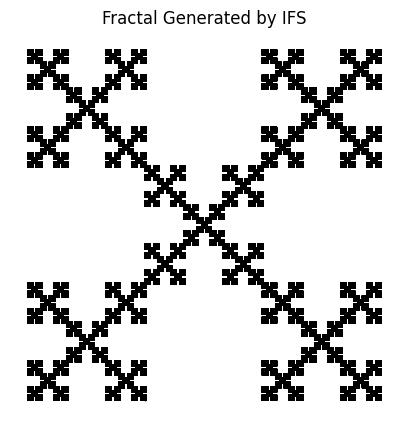

Similarity dimension ≈ 1.4650
Box-counting dimension (skip_extremes=2): 1.5090
  r_value=0.9998, p_value=2.648e-11, std_err=0.0129


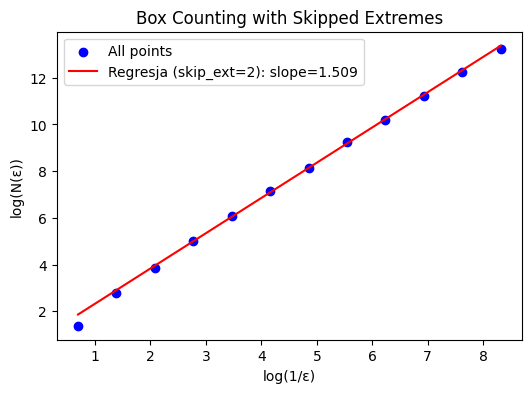

In [11]:
# VICSEK FRACTAL
# Expected dim = log(5)/log(3) = 1.465
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 1/3, 1/3),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

Modyfikacje fraktali klasycznych z losowością

In [12]:
import math, random

def generate_sierpinski_triangle_mod_ifs(scale_range=(0.3, 0.7), shift_range=0.5):
    scale1 = random.uniform(scale_range[0], scale_range[1])
    shift_x1 = random.uniform(-shift_range, shift_range)
    shift_y1 = random.uniform(-shift_range, shift_range)
    T1 = (
        scale1, 0.0,
        0.0,    scale1,
        shift_x1, shift_y1
    )
    
    scale2 = random.uniform(scale_range[0], scale_range[1])
    shift_x2 = 0.5 + random.uniform(-shift_range, shift_range)
    shift_y2 = 0.0 + random.uniform(-shift_range, shift_range)
    T2 = (
        scale2, 0.0,
        0.0,    scale2,
        shift_x2, shift_y2
    )
    
    scale3 = random.uniform(scale_range[0], scale_range[1])
    shift_x3 = 0.25 + random.uniform(-shift_range, shift_range)
    shift_y3 = (math.sqrt(3)/4) + random.uniform(-shift_range, shift_range)
    T3 = (
        scale3, 0.0,
        0.0,    scale3,
        shift_x3, shift_y3
    )
    
    transformations = [T1, T2, T3]
    probabilities = [1/3, 1/3, 1/3]

    return transformations, probabilities


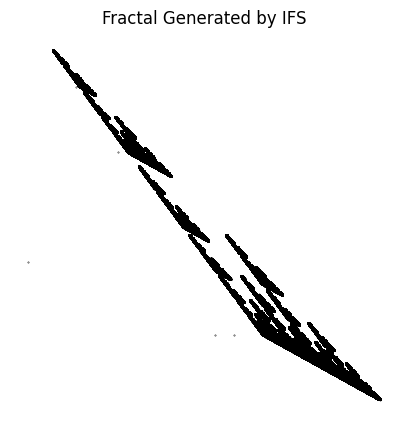

Similarity dimension ≈ 1.4875
Box-counting dimension (skip_extremes=2): 1.4312
  r_value=0.9999, p_value=1.258e-12, std_err=0.0074


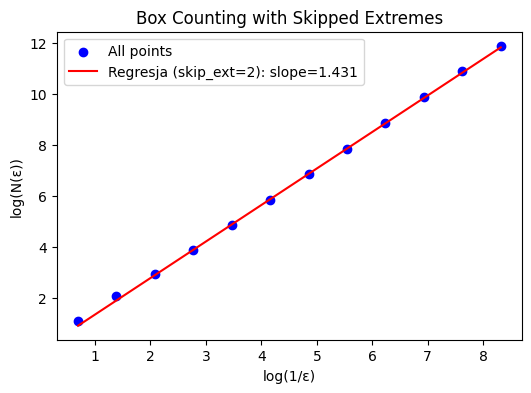

In [13]:
transformations, probabilities = generate_sierpinski_triangle_mod_ifs()
show_results(transformations, probabilities)

In [14]:
import random

def generate_sierpinski_carpet_mod_ifs(scale_range=(0.2, 0.4), shift_range=0.2):
    transformations = []
    
    for dx in range(3):
        for dy in range(3):
            if dx == 1 and dy == 1:
                continue
            
            a = random.uniform(scale_range[0], scale_range[1])
            d = a
            b = 0
            c = 0

            base_x = dx/3
            base_y = dy/3

            shift_x = random.uniform(-shift_range, shift_range)
            shift_y = random.uniform(-shift_range, shift_range)

            e = base_x + shift_x
            f = base_y + shift_y

            transformations.append((a, b, c, d, e, f))

    probabilities = [1/8]*len(transformations)

    return transformations, probabilities


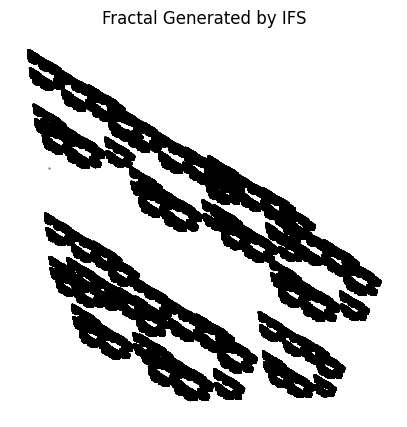

Similarity dimension ≈ 1.7642
Box-counting dimension (skip_extremes=2): 1.6906
  r_value=1.0000, p_value=3.236e-15, std_err=0.0032


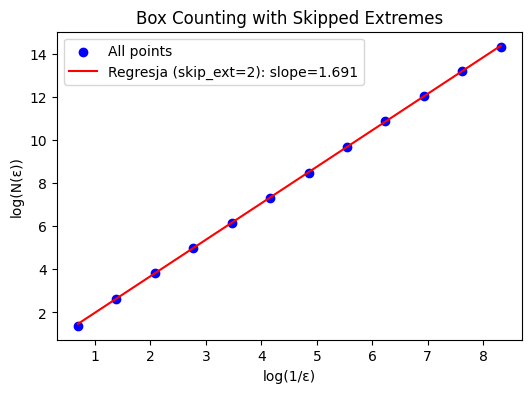

In [15]:
transformations, probabilities = generate_sierpinski_carpet_mod_ifs()
show_results(transformations, probabilities)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import permutations

def sample_triangle(points, num_samples=50):
    """
    Losowo generuje punkty wewnątrz trójkąta zadanego przez 3 wierzchołki.
    Używamy barycentrycznych współrzędnych (u, v), 
    przy czym jeśli u+v>1, odwracamy je, żeby pozostać w obrębie trójkąta.
    """
    (x1, y1), (x2, y2), (x3, y3) = points
    sampled_points = []
    for _ in range(num_samples):
        u, v = random.random(), random.random()
        # Jeśli u+v > 1, "odbicie" - trick barycentryczny
        if u + v > 1:
            u, v = 1 - u, 1 - v
        x = x1 + (x2 - x1)*u + (x3 - x1)*v
        y = y1 + (y2 - y1)*u + (y3 - y1)*v
        sampled_points.append((x, y))
    return sampled_points


def sierpinski_mod_rand(points, n, num_samples=50):
    """
    Rekurencyjnie generuje 'losowy' Sierpiński:
      - 'points' to tuple/list trzech wierzchołków aktualnego trójkąta,
      - n to głębokość rekurencji,
      - num_samples - ile punktów generujemy w danym trójkącie,
        gdy n=0 (poziom najgłębszy).

    Zwraca listę 2D-punktów (x,y) pokrywających trójkąt w najmniejszych podziałach.
    """
    # Jeśli dotarliśmy do poziomu 0 -> generujemy próbkę punktów w tym trójkącie
    if n == 0:
        return sample_triangle(points, num_samples=num_samples)
    
    # Wyznaczamy 3 punkty "środkowe"
    mid1 = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
    mid2 = ((points[1][0] + points[2][0]) / 2, (points[1][1] + points[2][1]) / 2)
    mid3 = ((points[0][0] + points[2][0]) / 2, (points[0][1] + points[2][1]) / 2)

    # Zmienna 'perm' - wszystkie permutacje środków,
    # z których "losowo" wybierzemy jeden zestaw.
    perm = permutations([mid1, mid2, mid3]) 
    
    # Rekurencyjnie dzielimy trójkąt na 3 "mniejsze", usuwając środkowy
    # -> standardowo Sierpinski to (A-mid1-mid3), (B-mid1-mid2), (C-mid2-mid3).
    # Tutaj jest drobna "modyfikacja": trzeci trójkąt wybieramy w oparciu o permutacje
    # i 'random.choice' dla "górnego" (losowa orientacja).
    
    sub_points = []
    sub_points.extend(sierpinski_mod_rand([points[0], mid1, mid3], n - 1, num_samples))
    sub_points.extend(sierpinski_mod_rand([points[1], mid1, mid2], n - 1, num_samples))
    # Losowo wybieramy jedną permutację z listy perm
    random_perm = random.choice(list(perm))  # np. (mid2, mid3, mid1) itp.
    sub_points.extend(sierpinski_mod_rand(random_perm, n - 1, num_samples))
    return sub_points


def draw_sierpinski_mod_rand(n, num_samples=50):
    """
    Tworzy modyfikowany, 'losowy' Sierpinski do głębokości n,
    generując ~ num_samples punktów w każdym najmniejszym trójkącie.

    Zwraca listę wszystkich punktów (x,y) - można je później
    użyć do box-countingu.
    """
    # Wywołanie rekurencyjne - główny (duży) trójkąt jednostkowy
    points = sierpinski_mod_rand(
        [(0, 0), (1, 0), (0.5, np.sqrt(3)/2)],  # wierzchołki "dużego" trójkąta
        n=n,
        num_samples=num_samples
    )
    points = np.array(points)

    # Rysunek uzyskanej chmury:
    plt.figure(figsize=(6,6))
    plt.scatter(points[:, 0], points[:, 1], s=0.5, color='green')
    plt.axis('equal')
    plt.axis('off')
    plt.title("Random Sierpiński (n={}, samples={})".format(n, num_samples))
    plt.show()

    return points  # => można użyć w box_count_2d


In [17]:
def show_results_2d(raw_points, epsilons, skip_extremes=2):    
    norm_points = normalize_to_unit_square(raw_points)
    # 5. Przygotowanie epsilons (jeśli None)
    if epsilons is None:
        # na przykład 9 wartości, 2^-1 do 2^-9
        epsilons = [2**(-i) for i in range(1, 13)]

    # 6. Obliczamy wymiar box-counting z pominięciem skrajnych wartości
    slope, intercept, r_value, p_value, std_err, logs, log_counts = compute_box_dimension_2d(
        norm_points,
        epsilons,
        skip_extremes=skip_extremes
    )
    print(f"Box-counting dimension (skip_extremes={skip_extremes}): {slope:.4f}")
    print(f"  r_value={r_value:.4f}, p_value={p_value:.4g}, std_err={std_err:.4f}")

    # 7. Rysunek log(N) vs log(1/eps)
    plt.figure(figsize=(6,4))
    plt.scatter(logs, log_counts, color='blue', label='All points')
    
    # Rysujemy linię regresji (uwzględniając pominięcie skrajnych punktów)
    slope_line = slope * logs + intercept
    plt.plot(logs, slope_line, color='red',
             label=f'Regresja (skip_ext={skip_extremes}): slope={slope:.3f}')
    plt.xlabel('log(1/ε)')
    plt.ylabel('log(N(ε))')
    plt.title('Box Counting with Skipped Extremes')
    plt.legend()
    plt.show()

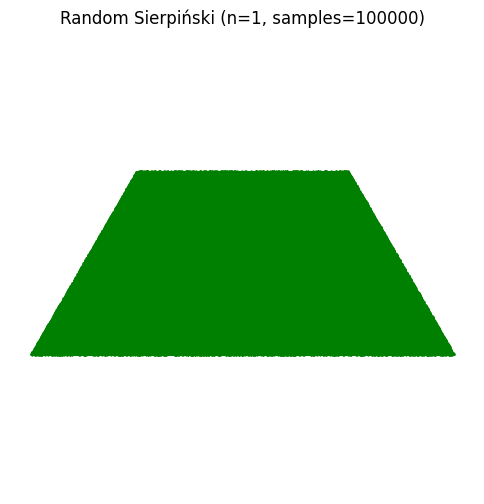

Box-counting dimension (skip_extremes=2): 1.8102
  r_value=0.9958, p_value=1.813e-07, std_err=0.0677


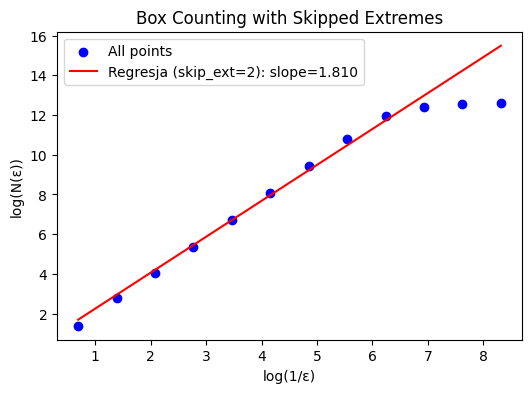

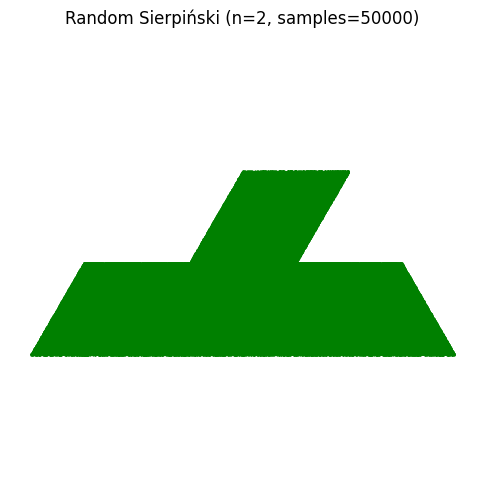

Box-counting dimension (skip_extremes=2): 1.8771
  r_value=0.9988, p_value=4.138e-09, std_err=0.0373


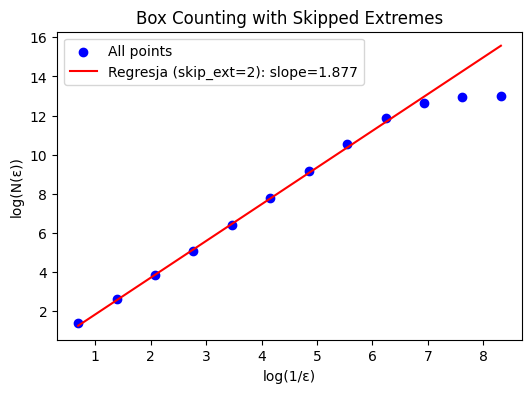

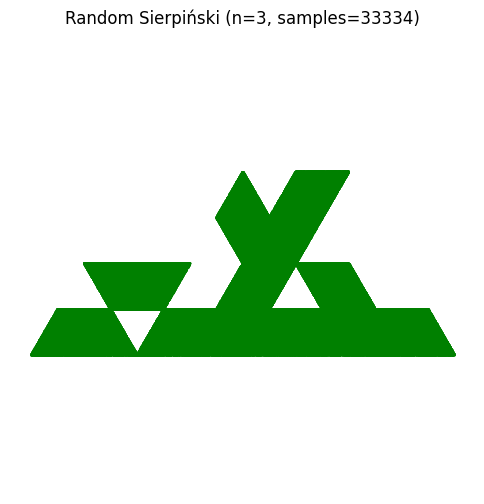

Box-counting dimension (skip_extremes=2): 1.8951
  r_value=0.9998, p_value=1.361e-11, std_err=0.0145


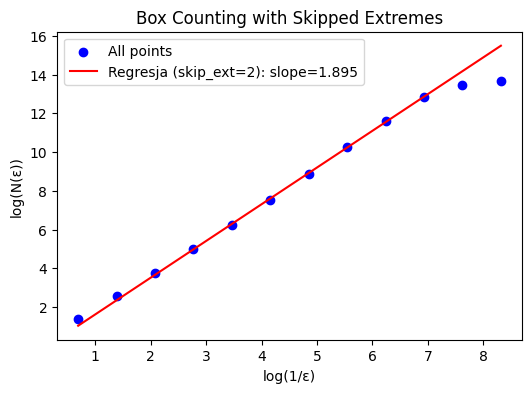

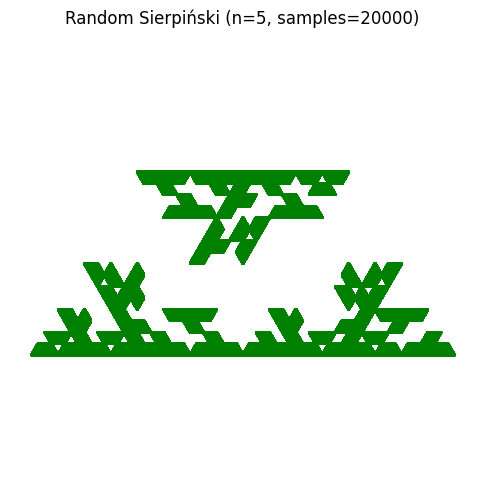

Box-counting dimension (skip_extremes=2): 1.8250
  r_value=0.9996, p_value=1.968e-10, std_err=0.0218


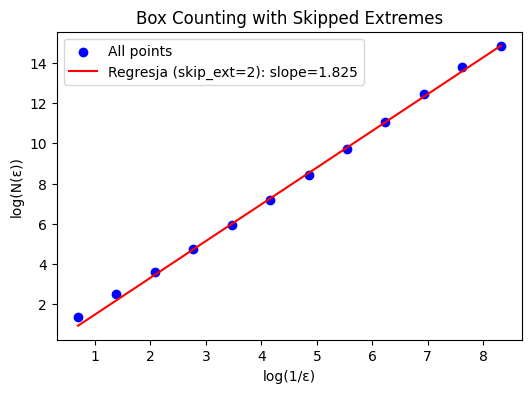

In [18]:
for iterations in [1, 2, 3, 5]:
    num_points=100000
    pts = draw_sierpinski_mod_rand(iterations, math.ceil(num_points/iterations))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

In [20]:
def sample_square(x, y, side_length, num_samples=50):
    """
    Losowo generuje punkty wewnątrz kwadratu [x, x+side_length] x [y, y+side_length].
    Zwraca listę krotek (px, py).
    """
    points = []
    for _ in range(num_samples):
        px = random.uniform(x, x + side_length)
        py = random.uniform(y, y + side_length)
        points.append((px, py))
    return points

def sierpinski_carpet_mod_rand_points(x, y, side_length, n, num_samples=50):
    """
    Rekurencyjnie generuje *chmurę punktów* (zamiast kwadratów).
      - (x, y)          : lewy dolny róg aktualnego kwadratu
      - side_length     : długość boku kwadratu
      - n               : liczba iteracji (głębokość fraktala)
      - num_samples     : ile punktów generować w każdej najmniejszej części (kiedy n=0)

    Zwraca listę par (px, py).
    """
    # jeżeli n=0, kończymy rekurencję i zwracamy losowe punkty w obrębie kwadratu:
    if n == 0:
        return sample_square(x, y, side_length, num_samples)
    
    # w przeciwnym wypadku dzielimy kwadrat na 9 części:
    new_side_length = side_length / 3
    points_list = []
    # losowy 9-bitowy wzorzec (0..511)
    keep_pattern = random.randint(0, 511)

    for dx in range(3):
        for dy in range(3):
            square_index = dy * 3 + dx
            # jeśli bit==0 => odrzucamy ten sub-kwadrat
            if not (keep_pattern & (1 << square_index)):
                continue
            
            new_x = x + dx * new_side_length
            new_y = y + dy * new_side_length
            # zbieramy punkty z rekurencji
            points_sub = sierpinski_carpet_mod_rand_points(
                new_x, new_y,
                new_side_length,
                n - 1,
                num_samples
            )
            points_list.extend(points_sub)
    
    return points_list

def draw_sierpinski_carpet_mod_rand_points(n, num_samples=50):
    """
    Generuje chmurę punktów reprezentującą losowy dywan Sierpińskiego (n iteracji),
    po czym rysuje je na wykresie scatter. Zwraca też listę (tablicę) punktów.
    
    Parametry:
      n            : głębokość rekurencji
      num_samples  : ile punktów generować w każdym najmniejszym kwadracie (gdy n=0)
    """
    # 1. Generujemy listę punktów w obrębie 'fraktala'
    points = sierpinski_carpet_mod_rand_points(0, 0, 1, n, num_samples=num_samples)
    points = np.array(points)

    # 2. Rysujemy chmurę
    plt.figure(figsize=(6,6))
    plt.scatter(points[:, 0], points[:, 1], s=0.5, color='green')
    plt.axis('equal')
    plt.axis('off')
    plt.title(f"Random Sierpinski Carpet (n={n}, samples={num_samples})")
    plt.show()

    # 3. Zwracamy listę punktów (np. do dalszych analiz, box-countingu etc.)
    return points


Box-counting dimension (skip_extremes=2): 1.8916
  r_value=0.9991, p_value=1.966e-09, std_err=0.0332


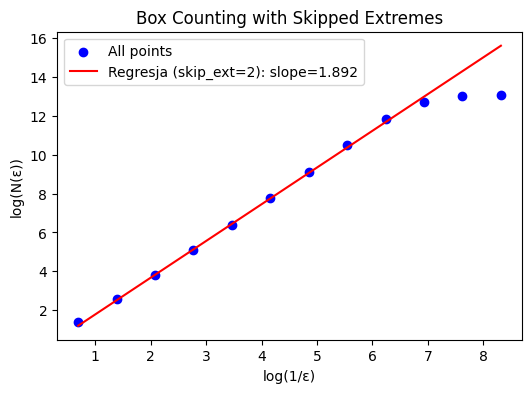

Box-counting dimension (skip_extremes=2): 1.8746
  r_value=0.9995, p_value=2.963e-10, std_err=0.0240


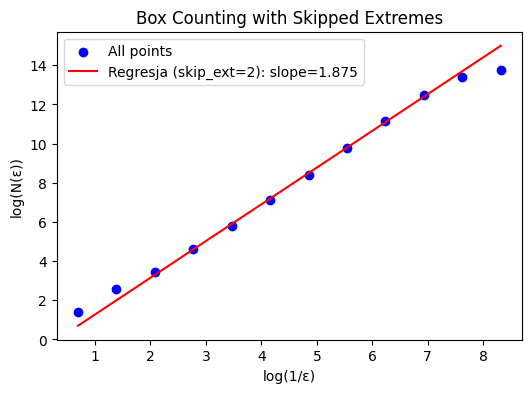

Box-counting dimension (skip_extremes=2): 1.7093
  r_value=0.9985, p_value=8.056e-09, std_err=0.0380


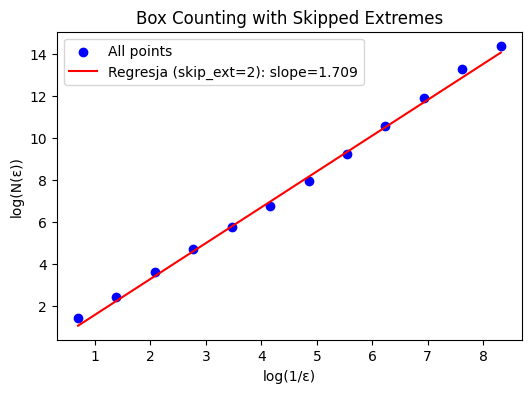

In [ ]:
for iterations in [1, 2, 3, 5]:
    num_points=100000
    pts = draw_sierpinski_carpet_mod_rand_points(iterations, math.ceil(num_points/iterations))
    show_results_2d(pts, epsilons=None, skip_extremes=2)